In [1]:
#!git clone https://github.com/beichenzbc/Long-CLIP.git

In [ ]:
#%cd Long-CLIP

C:\Users\14122\AppData\Local\Programs\Microsoft VS Code\Long-CLIP\Long-CLIP


In [24]:
# Change the working directory to the correct path
%cd "C:/Users/14122/AppData/Local/Programs/Microsoft VS Code/Long-CLIP"


C:\Users\14122\AppData\Local\Programs\Microsoft VS Code\Long-CLIP


In [1]:
%cd "F:/Github/MemePic/Long-CLIP/Long-CLIP"

F:\Github\MemePic\Long-CLIP\Long-CLIP


## 1. Data Preparation

In [2]:
image_path_MetMeme = "F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Direct_Added_Experience/Matte_Filtered"


In [3]:
import sklearn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from sklearn.metrics import classification_report
from model import longclip
import torch
from PIL import Image

# Load the CSV file
df_base = pd.read_csv("F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Direct_Added_Experience/Output_text.csv")

# Select the "intention_detection" column
intention_column = df_base["intention detection"]

# Encode the labels
#labels = encoder.fit_transform(intention_column)  # Encodes values like 1, 2, 3, 4, 5 into 0, 1, 2, 3, 4

encoder = LabelEncoder()
labels = encoder.fit_transform(intention_column)  # 输出 [0, 1, 2, 3, 4]

In [4]:
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few encoded labels
print("Encoded Labels (first 10):", labels[:10])

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
Encoded Labels (first 10): [3 1 2 2 2 2 2 0 2 2]


In [5]:
df_base["label_index"] = labels  # Add the labels to DataFrame 中
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few rows of the DataFrame
print(df_base.head())

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
          image_file                                       Overall Tone  \
0     image_ (0).jpg   The tone is lighthearted and self-deprecating...   
1    image_ (10).jpg  \n- The image conveys a sense of irony and hum...   
2  image_ (1000).jpg   The tone of the image is contemplative and ph...   
3  image_ (1001).jpg  \n- The tone of the image is emotional and pot...   
4  image_ (1003).jpg   The tone of the image is humorous and sarcast...   

  intention detection  label_index  
0        4(offensive)            3  
1       2(expressive)            1  
2     3(entertaining)            2  
3     3(entertaining)            2  
4     3(entertaining)            2  


In [6]:
# CLIP init

In [8]:
# 初始化CLIP处理器
device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = longclip.load("./checkpoints/longclip-B.pt", device=device)
model, preprocess = longclip.load("F:/Github/MemePic/Long-CLIP/checkpoints/longclip-B.pt", device=device)
model = model.float()  # 强制转换为float32



In [9]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class CLIPMemeDataset(Dataset):
    def __init__(self, df, image_root, preprocess):
        """
        Args:
            df: DataFrame包含image_file, Overall Tone, label_index列
            image_root: 图片存储根目录
            clip_preprocess: CLIP官方预处理函数（来自clip.load()）
        """
        self.df = df
        self.image_root = image_root
        self.preprocess = preprocess  # CLIP图像预处理器
        self.text_prefix = "The overall tone is: "  # 增强文本语义

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 获取数据行
        row = self.df.iloc[idx]
        
        # 1. 图像处理流水线
        image_path = os.path.join(self.image_root, row["image_file"])
        image = Image.open(image_path).convert("RGB")  # 强制转为RGB
        image_tensor = self.preprocess(image)          # CLIP标准预处理
        
        # 2. 文本处理流水线 
        text = self.text_prefix + row["Overall Tone"]  # 拼接提示词
        text_tensor = longclip.tokenize(text)              # CLIP标准分词
        
        # 3. 标签处理
        label = torch.tensor(row["label_index"], dtype=torch.long)
        
        return image_tensor, text_tensor.squeeze(0), label  # 压缩文本维度

In [10]:
def count_tokens(text):
    model, preprocess = longclip.load("./checkpoints/longclip-B.pt", device=device)
    tokens = longclip.tokenize(text, truncate=False)  # 禁用自动截断
    return tokens.shape[1]  # 返回实际token数

In [11]:
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=5):
        super().__init__()
        self.clip = clip_model
        # 冻结CLIP参数（可选）
        for param in self.clip.parameters():
            param.requires_grad = False
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, texts):
        image_features = self.clip.encode_image(images).float()
        text_features = self.clip.encode_text(texts).float()
        combined = torch.cat([image_features, text_features], dim=1)
        return self.classifier(combined)

In [12]:
# 创建数据集实例
dataset = CLIPMemeDataset(
    df=df_base,  # 需包含label_index列（0-4）
    image_root = image_path_MetMeme,
    preprocess=preprocess  # 注入CLIP预处理器
)


In [13]:
# 单样本维度检查
sample = dataset[0]
print(
    f"图像张量形状: {sample[0].shape}",  # 应为torch.Size([3, 224, 224])
    f"文本Token形状: {sample[1].shape}", # 应为torch.Size([248]) 
    f"标签类型: {type(sample[2])}"       # 应为torch.Tensor
)


图像张量形状: torch.Size([3, 224, 224]) 文本Token形状: torch.Size([248]) 标签类型: <class 'torch.Tensor'>


In [14]:
# DataLoader批次验证
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
for images, texts, labels in dataloader:
    assert images.shape == (4, 3, 224, 224), "图像批次形状错误"
    assert texts.shape == (4, 248), "文本批次形状错误"
    break

In [15]:
# 设置随机种子
torch.manual_seed(42)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [16]:
import torch.nn as nn
# 计算类别权重（应对0.2%的极端不平衡）
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced",
    classes=df_base["label_index"].unique(),
    y=df_base["label_index"]
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)



In [17]:
# 模型与优化器
model = MultimodalClassifier(model).to(device)
criterion = nn.CrossEntropyLoss(weight=weights) # 修改损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# 在训练循环中添加检查
print(images.dtype)   # 应输出 torch.float32
print(texts.dtype)    # 应输出 torch.int64
print(labels.dtype)   # 应输出 torch.int64

torch.float32
torch.int32
torch.int64


In [19]:
for epoch in range(100):  # 训练轮次
    model.train()
    total_loss = 0
    for images, texts, labels in train_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 1.1660
Epoch 2, Loss: 0.9805
Epoch 3, Loss: 0.9230
Epoch 4, Loss: 0.9057
Epoch 5, Loss: 0.8802
Epoch 6, Loss: 0.8503
Epoch 7, Loss: 0.8174
Epoch 8, Loss: 0.8119
Epoch 9, Loss: 0.7783
Epoch 10, Loss: 0.7476
Epoch 11, Loss: 0.7484
Epoch 12, Loss: 0.7311
Epoch 13, Loss: 0.7129
Epoch 14, Loss: 0.6963
Epoch 15, Loss: 0.6810
Epoch 16, Loss: 0.6764
Epoch 17, Loss: 0.6595
Epoch 18, Loss: 0.6512
Epoch 19, Loss: 0.6568
Epoch 20, Loss: 0.6387
Epoch 21, Loss: 0.6196
Epoch 22, Loss: 0.6232
Epoch 23, Loss: 0.6044
Epoch 24, Loss: 0.6086
Epoch 25, Loss: 0.5885
Epoch 26, Loss: 0.5856
Epoch 27, Loss: 0.5698
Epoch 28, Loss: 0.5607
Epoch 29, Loss: 0.5571
Epoch 30, Loss: 0.5575
Epoch 31, Loss: 0.5521
Epoch 32, Loss: 0.5343
Epoch 33, Loss: 0.5249
Epoch 34, Loss: 0.5255
Epoch 35, Loss: 0.5148
Epoch 36, Loss: 0.5009
Epoch 37, Loss: 0.4989
Epoch 38, Loss: 0.4885
Epoch 39, Loss: 0.4810
Epoch 40, Loss: 0.4717
Epoch 41, Loss: 0.4727
Epoch 42, Loss: 0.4652
Epoch 43, Loss: 0.4520
Epoch 44, Loss: 0.44

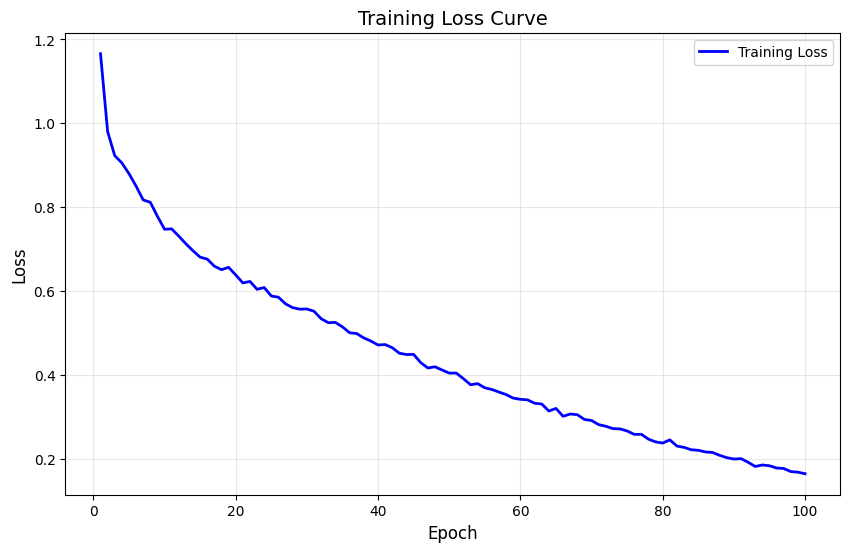

In [20]:
import re
import matplotlib.pyplot as plt

# 将日志内容复制到字符串中
log_data = """
Epoch 1, Loss: 1.1660
Epoch 2, Loss: 0.9805
Epoch 3, Loss: 0.9230
Epoch 4, Loss: 0.9057
Epoch 5, Loss: 0.8802
Epoch 6, Loss: 0.8503
Epoch 7, Loss: 0.8174
Epoch 8, Loss: 0.8119
Epoch 9, Loss: 0.7783
Epoch 10, Loss: 0.7476
Epoch 11, Loss: 0.7484
Epoch 12, Loss: 0.7311
Epoch 13, Loss: 0.7129
Epoch 14, Loss: 0.6963
Epoch 15, Loss: 0.6810
Epoch 16, Loss: 0.6764
Epoch 17, Loss: 0.6595
Epoch 18, Loss: 0.6512
Epoch 19, Loss: 0.6568
Epoch 20, Loss: 0.6387
Epoch 21, Loss: 0.6196
Epoch 22, Loss: 0.6232
Epoch 23, Loss: 0.6044
Epoch 24, Loss: 0.6086
Epoch 25, Loss: 0.5885
Epoch 26, Loss: 0.5856
Epoch 27, Loss: 0.5698
Epoch 28, Loss: 0.5607
Epoch 29, Loss: 0.5571
Epoch 30, Loss: 0.5575
Epoch 31, Loss: 0.5521
Epoch 32, Loss: 0.5343
Epoch 33, Loss: 0.5249
Epoch 34, Loss: 0.5255
Epoch 35, Loss: 0.5148
Epoch 36, Loss: 0.5009
Epoch 37, Loss: 0.4989
Epoch 38, Loss: 0.4885
Epoch 39, Loss: 0.4810
Epoch 40, Loss: 0.4717
Epoch 41, Loss: 0.4727
Epoch 42, Loss: 0.4652
Epoch 43, Loss: 0.4520
Epoch 44, Loss: 0.4489
Epoch 45, Loss: 0.4492
Epoch 46, Loss: 0.4296
Epoch 47, Loss: 0.4168
Epoch 48, Loss: 0.4197
Epoch 49, Loss: 0.4120
Epoch 50, Loss: 0.4047
Epoch 51, Loss: 0.4047
Epoch 52, Loss: 0.3913
Epoch 53, Loss: 0.3769
Epoch 54, Loss: 0.3795
Epoch 55, Loss: 0.3696
Epoch 56, Loss: 0.3656
Epoch 57, Loss: 0.3594
Epoch 58, Loss: 0.3534
Epoch 59, Loss: 0.3450
Epoch 60, Loss: 0.3422
Epoch 61, Loss: 0.3409
Epoch 62, Loss: 0.3328
Epoch 63, Loss: 0.3310
Epoch 64, Loss: 0.3143
Epoch 65, Loss: 0.3204
Epoch 66, Loss: 0.3017
Epoch 67, Loss: 0.3071
Epoch 68, Loss: 0.3055
Epoch 69, Loss: 0.2942
Epoch 70, Loss: 0.2917
Epoch 71, Loss: 0.2818
Epoch 72, Loss: 0.2780
Epoch 73, Loss: 0.2723
Epoch 74, Loss: 0.2716
Epoch 75, Loss: 0.2667
Epoch 76, Loss: 0.2586
Epoch 77, Loss: 0.2587
Epoch 78, Loss: 0.2472
Epoch 79, Loss: 0.2407
Epoch 80, Loss: 0.2379
Epoch 81, Loss: 0.2455
Epoch 82, Loss: 0.2307
Epoch 83, Loss: 0.2276
Epoch 84, Loss: 0.2220
Epoch 85, Loss: 0.2206
Epoch 86, Loss: 0.2167
Epoch 87, Loss: 0.2155
Epoch 88, Loss: 0.2086
Epoch 89, Loss: 0.2031
Epoch 90, Loss: 0.1998
Epoch 91, Loss: 0.2007
Epoch 92, Loss: 0.1921
Epoch 93, Loss: 0.1821
Epoch 94, Loss: 0.1856
Epoch 95, Loss: 0.1838
Epoch 96, Loss: 0.1784
Epoch 97, Loss: 0.1773
Epoch 98, Loss: 0.1699
Epoch 99, Loss: 0.1685
Epoch 100, Loss: 0.1648
"""

# 提取 loss 值
losses = [float(match.group(1)) for match in re.finditer(r"Loss: ([0-9.]+)", log_data)]

# 绘制曲线
epochs = list(range(1, len(losses) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [50]:
losses = [
    0.7746, 0.7526, 0.7463, 0.7360, 0.7211, 0.7120, 0.7018, 0.6942, 0.6776, 0.6827,
    0.6574, 0.6521, 0.6492, 0.6259, 0.6166, 0.6123, 0.6075, 0.5906, 0.5844, 0.5948,
    0.5882, 0.5682, 0.5654, 0.5570, 0.5487, 0.5496, 0.5396, 0.5316, 0.5192, 0.5085,
    0.5113, 0.4991, 0.4921, 0.4845, 0.4728, 0.4765, 0.4628, 0.4503, 0.4507, 0.4465,
    0.4378, 0.4276, 0.4263, 0.4234, 0.4175, 0.4053, 0.4023, 0.3882, 0.3867, 0.3887,
    0.3779, 0.3744, 0.3707, 0.3564, 0.3535, 0.3503, 0.3405, 0.3430, 0.3316, 0.3273,
    0.3221, 0.3142, 0.3151, 0.3098, 0.3063, 0.2977, 0.2915, 0.2829, 0.2795, 0.2828,
    0.2783, 0.2683, 0.2693, 0.2598, 0.2538, 0.2517, 0.2472, 0.2419, 0.2381, 0.2358,
    0.2264, 0.2321, 0.2258, 0.2222, 0.2133, 0.2088, 0.2061, 0.2048, 0.2000, 0.1977,
    0.1895, 0.1892, 0.1893, 0.1856, 0.1798, 0.1756, 0.1722, 0.1707, 0.1652, 0.1638
]

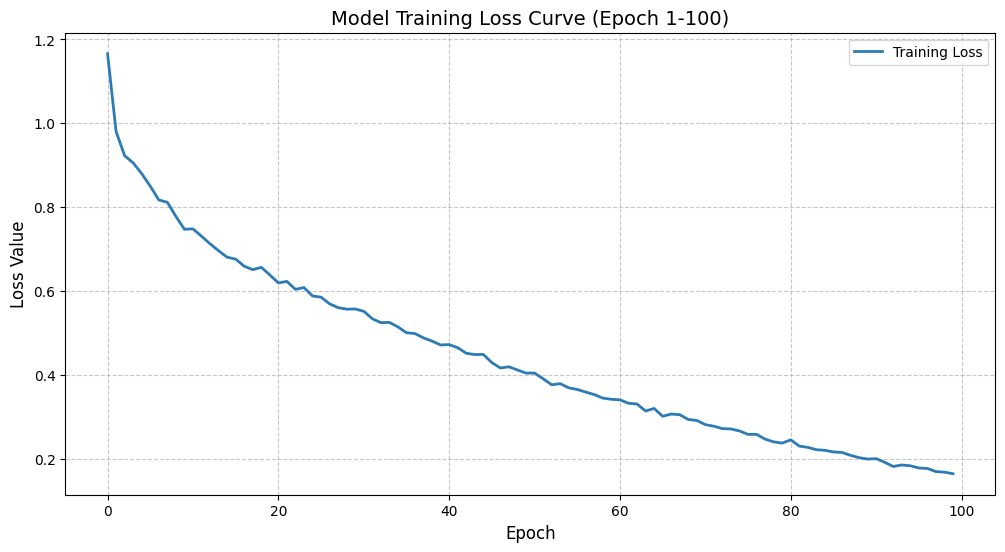

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(losses, color='#2c7bb6', linewidth=2, label='Training Loss')
plt.title("Model Training Loss Curve (Epoch 1-100)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

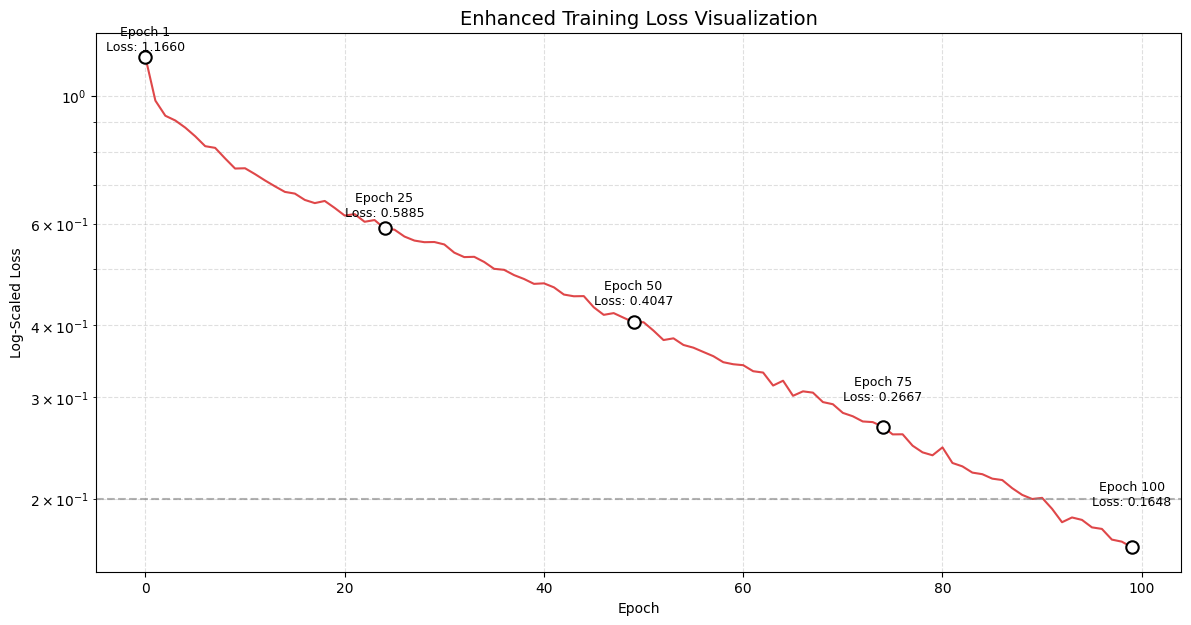

In [22]:
import numpy as np

plt.figure(figsize=(14, 7))
plt.plot(losses, color='#d7191c', linewidth=1.5, alpha=0.8)

# 标记关键点
key_epochs = [1, 25, 50, 75, 100]
for epoch in key_epochs:
    plt.scatter(epoch-1, losses[epoch-1], s=80, 
                edgecolors='black', facecolor='white', 
                linewidth=1.5, zorder=3)
    plt.text(epoch-1, losses[epoch-1]+0.03, 
             f'Epoch {epoch}\nLoss: {losses[epoch-1]:.4f}',
             ha='center', fontsize=9)

plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.6)
plt.yscale('log')  # 对数坐标更清晰展示后期变化
plt.title("Enhanced Training Loss Visualization", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Log-Scaled Loss")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data for epochs and corresponding losses
epochs = list(range(1, 101))  # Assuming 100 epochsimport matplotlib.pyplot as plt

# Example data for epochs and corresponding losses
epochs = list(range(1, 101))  # Assuming 100 epochs

In [23]:
# -------------------- 6. 评估 --------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, texts, labels in test_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        outputs = model(images, texts)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=encoder.classes_))



                 precision    recall  f1-score   support

 1(interactive)       0.15      0.07      0.10        28
  2(expressive)       0.40      0.40      0.40       154
3(entertaining)       0.51      0.43      0.47       199
   4(offensive)       0.48      0.63      0.54       155
       5(other)       0.00      0.00      0.00         1

       accuracy                           0.46       537
      macro avg       0.31      0.31      0.30       537
   weighted avg       0.45      0.46      0.45       537



c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
# -------------------- 7. 推理函数 --------------------
def predict(image_path, text, model, preprocess, encoder):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text_tensor = clip.tokenize([f"Tone: {text}"]).to(device)
    
    with torch.no_grad():
        logits = model(image, text_tensor)
        probs = torch.softmax(logits, dim=1)
    
    return {
        "class": encoder.inverse_transform([logits.argmax().item()])[0],
        "confidence": round(probs.max().item(), 4)
    }

# 示例调用
result = predict("test_image.jpg", "sarcastic", model, preprocess, encoder)
print(result)  # 输出: {'class': 'entertaining', 'confidence': 0.9567}

# With matte pic

In [2]:
%cd "F:/Github/MemePic/Long-CLIP/Long-CLIP"

F:\Github\MemePic\Long-CLIP\Long-CLIP


In [24]:
image_path_MetMeme = "F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Direct_Added_Experience/remaining_foregrounds"
Matte = "F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Direct_Added_Experience/Matte_Filtered"

In [25]:
import sklearn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from sklearn.metrics import classification_report
from model import longclip
import torch
from PIL import Image

# Load the CSV file
df_base = pd.read_csv("F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Direct_Added_Experience/Output_text.csv")

# Select the "intention_detection" column
intention_column = df_base["intention detection"]

# Encode the labels
#labels = encoder.fit_transform(intention_column)  # Encodes values like 1, 2, 3, 4, 5 into 0, 1, 2, 3, 4

encoder = LabelEncoder()
labels = encoder.fit_transform(intention_column)  # 输出 [0, 1, 2, 3, 4]

In [26]:
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few encoded labels
print("Encoded Labels (first 10):", labels[:10])

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
Encoded Labels (first 10): [3 1 2 2 2 2 2 0 2 2]


In [27]:
df_base["label_index"] = labels  # Add the labels to DataFrame 中
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few rows of the DataFrame
print(df_base.head())

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
          image_file                                       Overall Tone  \
0     image_ (0).jpg   The tone is lighthearted and self-deprecating...   
1    image_ (10).jpg  \n- The image conveys a sense of irony and hum...   
2  image_ (1000).jpg   The tone of the image is contemplative and ph...   
3  image_ (1001).jpg  \n- The tone of the image is emotional and pot...   
4  image_ (1003).jpg   The tone of the image is humorous and sarcast...   

  intention detection  label_index  
0        4(offensive)            3  
1       2(expressive)            1  
2     3(entertaining)            2  
3     3(entertaining)            2  
4     3(entertaining)            2  


In [28]:
# 初始化CLIP处理器
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = longclip.load("F:/Github/MemePic/Long-CLIP/checkpoints/longclip-B.pt", device=device)
model = model.float()  # 强制转换为float32



F:\Github\MemePic\Long-CLIP\Long-CLIP\model\longclip.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location="cpu")


In [29]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class CLIPMemeDataset(Dataset):
    def __init__(self, df, image_root, foreground_root, preprocess):
        """
        Args:
            df: DataFrame 包含 image_file, Overall Tone, label_index 列
            image_root: 原图存储根目录
            foreground_root: 前景图存储根目录
            preprocess: CLIP 官方预处理函数（来自 clip.load()）
        """
        self.df = df
        self.image_root = image_root
        self.foreground_root = foreground_root
        self.preprocess = preprocess  # CLIP 图像预处理器
        self.text_prefix = "The overall tone is: "  # 增强文本语义

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 获取数据行
        row = self.df.iloc[idx]

        # 1. 原图处理流水线
        image_path = os.path.join(self.image_root, row["image_file"])
        image = Image.open(image_path).convert("RGB")  # 强制转为 RGB
        image_tensor = self.preprocess(image)  # CLIP 标准预处理

        # 2. 前景图处理流水线
        foreground_path = os.path.join(self.foreground_root, row["image_file"])
        foreground = Image.open(foreground_path).convert("RGB")  # 强制转为 RGB
        foreground_tensor = self.preprocess(foreground)  # CLIP 标准预处理

        # 3. 文本处理流水线
        text = self.text_prefix + row["Overall Tone"]  # 拼接提示词
        text_tensor = longclip.tokenize(text)  # CLIP 标准分词

        # 4. 标签处理
        label = torch.tensor(row["label_index"], dtype=torch.long)

        return image_tensor, foreground_tensor, text_tensor.squeeze(0), label  # 返回原图、前景图、文本和标签

In [30]:
def count_tokens(text):
    #model, preprocess = longclip.load("./checkpoints/longclip-B.pt", device=device)
    tokens = longclip.tokenize(text, truncate=False)  # 禁用自动截断
    return tokens.shape[1]  # 返回实际token数

In [31]:
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=5):
        super().__init__()
        self.clip = clip_model
        # 冻结 CLIP 参数（可选）
        for param in self.clip.parameters():
            param.requires_grad = False
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3, 256),  # 512 * 3：原图特征 + 前景图特征 + 文本特征
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, foregrounds, texts):
        # 提取原图特征
        image_features = self.clip.encode_image(images).float()
        # 提取前景图特征
        foreground_features = self.clip.encode_image(foregrounds).float()
        # 提取文本特征
        text_features = self.clip.encode_text(texts).float()
        # 合并特征
        combined = torch.cat([image_features, foreground_features, text_features], dim=1)
        return self.classifier(combined)

In [32]:
# 创建数据集实例
dataset = CLIPMemeDataset(
    df=df_base,  # 需包含 label_index 列（0-4）
    image_root=image_path_MetMeme,  # 原图路径
    foreground_root=Matte,  # 前景图路径
    preprocess=preprocess  # 注入 CLIP 预处理器
)

In [33]:
# 检查单个样本
sample = dataset[0]
print(
    f"原图张量形状: {sample[0].shape}",  # 应为 torch.Size([3, 224, 224])
    f"前景图张量形状: {sample[1].shape}",  # 应为 torch.Size([3, 224, 224])
    f"文本 Token 形状: {sample[2].shape}",  # 应为 torch.Size([248])
    f"标签类型: {type(sample[3])}"  # 应为 torch.Tensor
)

原图张量形状: torch.Size([3, 224, 224]) 前景图张量形状: torch.Size([3, 224, 224]) 文本 Token 形状: torch.Size([248]) 标签类型: <class 'torch.Tensor'>


In [34]:
from torch.utils.data import DataLoader

In [35]:
# DataLoader批次验证
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
for images, foregrounds, texts, labels in dataloader:
    assert images.shape == (4, 3, 224, 224), "原图批次形状错误"
    assert foregrounds.shape == (4, 3, 224, 224), "前景图批次形状错误"
    assert texts.shape == (4, 248), "文本批次形状错误"
    assert labels.shape == (4,), "标签批次形状错误"
    break

In [36]:
# 设置随机种子
torch.manual_seed(42)

# 数据集划分
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [37]:
import torch.nn as nn
# 计算类别权重（应对0.2%的极端不平衡）
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced",
    classes=df_base["label_index"].unique(),
    y=df_base["label_index"]
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)



In [38]:
# 模型与优化器
model = MultimodalClassifier(model).to(device)
criterion = nn.CrossEntropyLoss(weight=weights) # 修改损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [39]:
# 在训练循环中添加检查
print(images.dtype)   # 应输出 torch.float32
print(foregrounds.dtype)  # 应输出 torch.float32
print(texts.dtype)    # 应输出 torch.int64
print(labels.dtype)   # 应输出 torch.int64

torch.float32
torch.float32
torch.int32
torch.int64


In [40]:
for epoch in range(100):  # 训练轮次
    model.train()
    total_loss = 0
    for images, foregrounds, texts, labels in train_loader:  # 加入 foregrounds
        images, foregrounds, texts, labels = (
            images.to(device),
            foregrounds.to(device),
            texts.to(device),
            labels.to(device),
        )
        
        optimizer.zero_grad()
        outputs = model(images, foregrounds, texts)  # 修改为同时传入 images 和 foregrounds
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 1.1197
Epoch 2, Loss: 0.9544
Epoch 3, Loss: 0.9120
Epoch 4, Loss: 0.8582
Epoch 5, Loss: 0.8307
Epoch 6, Loss: 0.7959
Epoch 7, Loss: 0.7594
Epoch 8, Loss: 0.7361
Epoch 9, Loss: 0.7164
Epoch 10, Loss: 0.6965
Epoch 11, Loss: 0.6861
Epoch 12, Loss: 0.6538
Epoch 13, Loss: 0.6514
Epoch 14, Loss: 0.6357
Epoch 15, Loss: 0.6155
Epoch 16, Loss: 0.6059
Epoch 17, Loss: 0.5866
Epoch 18, Loss: 0.5766
Epoch 19, Loss: 0.5689
Epoch 20, Loss: 0.5470
Epoch 21, Loss: 0.5325
Epoch 22, Loss: 0.5312
Epoch 23, Loss: 0.5140
Epoch 24, Loss: 0.4955
Epoch 25, Loss: 0.5011
Epoch 26, Loss: 0.4767
Epoch 27, Loss: 0.4827
Epoch 28, Loss: 0.4584
Epoch 29, Loss: 0.4529
Epoch 30, Loss: 0.4398
Epoch 31, Loss: 0.4311
Epoch 32, Loss: 0.4142
Epoch 33, Loss: 0.4049
Epoch 34, Loss: 0.3928
Epoch 35, Loss: 0.3840
Epoch 36, Loss: 0.3728
Epoch 37, Loss: 0.3666
Epoch 38, Loss: 0.3560
Epoch 39, Loss: 0.3457
Epoch 40, Loss: 0.3338
Epoch 41, Loss: 0.3187
Epoch 42, Loss: 0.3181
Epoch 43, Loss: 0.3114
Epoch 44, Loss: 0.30

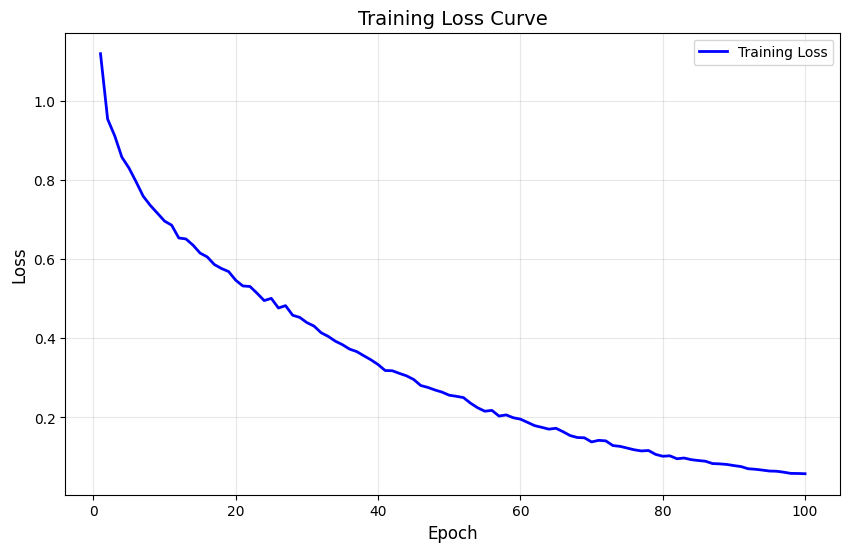

In [41]:
import re
import matplotlib.pyplot as plt

# 将日志内容复制到字符串中
log_data = """
Epoch 1, Loss: 1.1197
Epoch 2, Loss: 0.9544
Epoch 3, Loss: 0.9120
Epoch 4, Loss: 0.8582
Epoch 5, Loss: 0.8307
Epoch 6, Loss: 0.7959
Epoch 7, Loss: 0.7594
Epoch 8, Loss: 0.7361
Epoch 9, Loss: 0.7164
Epoch 10, Loss: 0.6965
Epoch 11, Loss: 0.6861
Epoch 12, Loss: 0.6538
Epoch 13, Loss: 0.6514
Epoch 14, Loss: 0.6357
Epoch 15, Loss: 0.6155
Epoch 16, Loss: 0.6059
Epoch 17, Loss: 0.5866
Epoch 18, Loss: 0.5766
Epoch 19, Loss: 0.5689
Epoch 20, Loss: 0.5470
Epoch 21, Loss: 0.5325
Epoch 22, Loss: 0.5312
Epoch 23, Loss: 0.5140
Epoch 24, Loss: 0.4955
Epoch 25, Loss: 0.5011
Epoch 26, Loss: 0.4767
Epoch 27, Loss: 0.4827
Epoch 28, Loss: 0.4584
Epoch 29, Loss: 0.4529
Epoch 30, Loss: 0.4398
Epoch 31, Loss: 0.4311
Epoch 32, Loss: 0.4142
Epoch 33, Loss: 0.4049
Epoch 34, Loss: 0.3928
Epoch 35, Loss: 0.3840
Epoch 36, Loss: 0.3728
Epoch 37, Loss: 0.3666
Epoch 38, Loss: 0.3560
Epoch 39, Loss: 0.3457
Epoch 40, Loss: 0.3338
Epoch 41, Loss: 0.3187
Epoch 42, Loss: 0.3181
Epoch 43, Loss: 0.3114
Epoch 44, Loss: 0.3052
Epoch 45, Loss: 0.2961
Epoch 46, Loss: 0.2808
Epoch 47, Loss: 0.2759
Epoch 48, Loss: 0.2694
Epoch 49, Loss: 0.2640
Epoch 50, Loss: 0.2562
Epoch 51, Loss: 0.2535
Epoch 52, Loss: 0.2502
Epoch 53, Loss: 0.2360
Epoch 54, Loss: 0.2244
Epoch 55, Loss: 0.2158
Epoch 56, Loss: 0.2178
Epoch 57, Loss: 0.2035
Epoch 58, Loss: 0.2064
Epoch 59, Loss: 0.1993
Epoch 60, Loss: 0.1957
Epoch 61, Loss: 0.1876
Epoch 62, Loss: 0.1793
Epoch 63, Loss: 0.1750
Epoch 64, Loss: 0.1704
Epoch 65, Loss: 0.1726
Epoch 66, Loss: 0.1639
Epoch 67, Loss: 0.1541
Epoch 68, Loss: 0.1493
Epoch 69, Loss: 0.1485
Epoch 70, Loss: 0.1381
Epoch 71, Loss: 0.1421
Epoch 72, Loss: 0.1408
Epoch 73, Loss: 0.1289
Epoch 74, Loss: 0.1269
Epoch 75, Loss: 0.1226
Epoch 76, Loss: 0.1182
Epoch 77, Loss: 0.1153
Epoch 78, Loss: 0.1164
Epoch 79, Loss: 0.1066
Epoch 80, Loss: 0.1019
Epoch 81, Loss: 0.1030
Epoch 82, Loss: 0.0956
Epoch 83, Loss: 0.0974
Epoch 84, Loss: 0.0933
Epoch 85, Loss: 0.0911
Epoch 86, Loss: 0.0893
Epoch 87, Loss: 0.0834
Epoch 88, Loss: 0.0826
Epoch 89, Loss: 0.0812
Epoch 90, Loss: 0.0783
Epoch 91, Loss: 0.0758
Epoch 92, Loss: 0.0703
Epoch 93, Loss: 0.0690
Epoch 94, Loss: 0.0669
Epoch 95, Loss: 0.0645
Epoch 96, Loss: 0.0640
Epoch 97, Loss: 0.0616
Epoch 98, Loss: 0.0585
Epoch 99, Loss: 0.0583
Epoch 100, Loss: 0.0577
"""

# 提取 loss 值
losses = [float(match.group(1)) for match in re.finditer(r"Loss: ([0-9.]+)", log_data)]

# 绘制曲线
epochs = list(range(1, len(losses) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Training Loss", color="blue", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

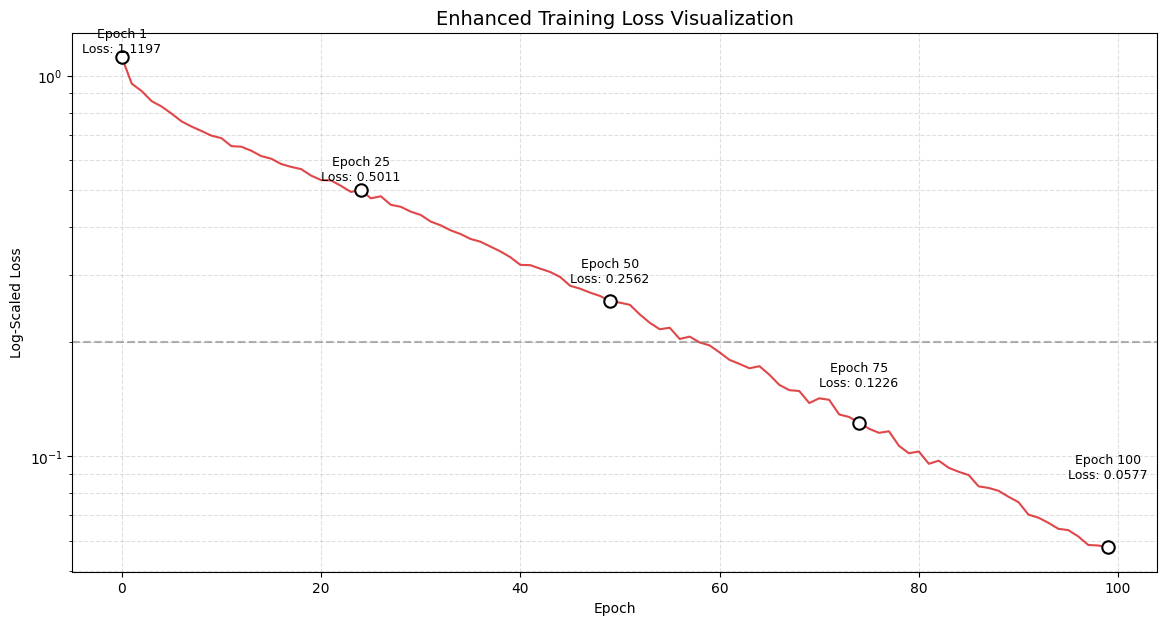

In [42]:
import numpy as np

plt.figure(figsize=(14, 7))
plt.plot(losses, color='#d7191c', linewidth=1.5, alpha=0.8)

# 标记关键点
key_epochs = [1, 25, 50, 75, 100]
for epoch in key_epochs:
    plt.scatter(epoch-1, losses[epoch-1], s=80, 
                edgecolors='black', facecolor='white', 
                linewidth=1.5, zorder=3)
    plt.text(epoch-1, losses[epoch-1]+0.03, 
             f'Epoch {epoch}\nLoss: {losses[epoch-1]:.4f}',
             ha='center', fontsize=9)

plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.6)
plt.yscale('log')  # 对数坐标更清晰展示后期变化
plt.title("Enhanced Training Loss Visualization", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Log-Scaled Loss")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

In [43]:
# -------------------- 6. 评估 --------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, foregrounds, texts, labels in test_loader:  # 加入 foregrounds
        images, foregrounds, texts, labels = (
            images.to(device),
            foregrounds.to(device),
            texts.to(device),
            labels.to(device),
        )
        outputs = model(images, foregrounds, texts)  # 修改为同时传入 images 和 foregrounds
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 1(interactive)       0.09      0.04      0.05        28
  2(expressive)       0.33      0.30      0.31       154
3(entertaining)       0.47      0.51      0.49       199
   4(offensive)       0.51      0.57      0.54       155
       5(other)       0.00      0.00      0.00         1

       accuracy                           0.44       537
      macro avg       0.28      0.28      0.28       537
   weighted avg       0.42      0.44      0.43       537



c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu